# Vector Autoregression (VAR) Analysis of Picnic Basket Components

This notebook performs Vector Autoregression (VAR) analysis on the products that make up the picnic baskets to model their dynamic relationships and forecast future values.

## Picnic Basket Compositions:
- PICNIC_BASKET1 = 6 × CROISSANTS + 3 × JAMS + 1 × DJEMBE
- PICNIC_BASKET2 = 4 × CROISSANTS + 2 × JAMS

In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Data Loading

First, we'll load the price data for all products that make up the picnic baskets.

In [2]:
# Add the parent directory to the path to import backtester
sys.path.append(os.path.abspath('../../'))

# Try to import the backtester package
try:
    from backtester import get_price_data
    print("Successfully imported backtester.get_price_data")
except ImportError:
    print("Could not import backtester. Trying alternative method...")
    
    # Define a function to load price data from CSV files
    def load_price_data(round_num, day_num):
        # Path to data directory
        data_path = '../../../Prosperity 3 Data'
        
        # Construct file path
        file_path = os.path.join(data_path, f'Round {round_num}/prices_round_{round_num}_day_{day_num}.csv')
        
        # Check if file exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return pd.DataFrame()
        
        # Load data
        data = pd.read_csv(file_path, sep=';')
        
        return data
    
    def get_price_data(product, round_num):
        all_data = pd.DataFrame()
        
        for day in range(-2, 1):
            try:
                data = load_price_data(round_num, day)
                if not data.empty:
                    # Adjust timestamp to create a continuous series
                    data['timestamp'] += (day + 2) * 1000000
                    all_data = pd.concat([all_data, data])
            except Exception as e:
                print(f"Error loading data for day {day}: {e}")
        
        return all_data

Successfully imported backtester.get_price_data


In [3]:
# Define the products we want to analyze
products = ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'PICNIC_BASKET2']

# Load data for each product
product_data = {}

for product in products:
    try:
        data = get_price_data(product, 2)  # Round 2 data
        if not data.empty:
            product_data[product] = data
            print(f"Loaded {len(data)} rows of {product} data")
        else:
            print(f"No data found for {product}")
    except Exception as e:
        print(f"Error loading {product} data: {e}")

Loading real data for CROISSANTS from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of CROISSANTS data
Loading real data for JAMS from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of JAMS data
Loading real data for DJEMBES from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found da

In [4]:
# Extract VWAP and create a combined DataFrame
prices_df = pd.DataFrame()

for product, data in product_data.items():
    if not data.empty:
        # Check if 'vwap' column exists
        if 'vwap' in data.columns:
            # Extract timestamp and vwap
            product_prices = data.reset_index()[['timestamp', 'vwap']].copy()
            product_prices.columns = ['timestamp', product]
            
            # Merge with the combined DataFrame
            if prices_df.empty:
                prices_df = product_prices
            else:
                prices_df = pd.merge(prices_df, product_prices, on='timestamp', how='outer')
        else:
            print(f"Warning: 'vwap' column not found in {product} data")

# Sort by timestamp
if not prices_df.empty:
    prices_df = prices_df.sort_values('timestamp')
    prices_df = prices_df.set_index('timestamp')
    
    # Display the first few rows
    print("Combined price data:")
    display(prices_df.head())
    
    # Display basic statistics
    print("\nBasic statistics:")
    display(prices_df.describe())
    
    # Check for missing values
    print("\nMissing values per column:")
    display(prices_df.isna().sum())
else:
    print("No price data available for analysis")

Combined price data:


,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1,PICNIC_BASKET2
timestamp,,,,,
0,4304.5,6670.5,13450.500000,59289.236842,30609.000000
100,4304.5,6670.5,13450.000000,59287.472973,30612.729730
200,4304.5,6671.0,13450.196078,59293.500000,30614.696970
300,4304.5,6672.0,13450.000000,59293.500000,30620.302326
400,4305.5,6672.0,13452.500000,59291.779412,30622.312500



Basic statistics:


,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1,PICNIC_BASKET2
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,4297.842360,6593.315687,13436.233067,59051.991852,30408.240942
std,23.777760,59.546051,42.950624,363.666332,214.973921
min,4251.000000,6498.500000,13353.000000,58397.500000,29987.326531
25%,4274.176618,6529.000000,13395.500000,58678.500000,30236.338816
50%,4304.500000,6610.000000,13444.500000,59142.500000,30426.292560
75%,4318.779070,6636.500000,13470.162419,59335.625000,30589.663288
max,4340.500000,6702.500000,13519.500000,59786.500000,30813.000000



Missing values per column:


CROISSANTS        0
JAMS              0
DJEMBES           0
PICNIC_BASKET1    0
PICNIC_BASKET2    0
dtype: int64

## Data Preprocessing

For VAR analysis, we need to work with stationary time series. We'll calculate log returns and test for stationarity.

Log returns:


,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1,PICNIC_BASKET2
timestamp,,,,,
100,0.000000,0.000000,-0.000037,-0.000030,0.000122
200,0.000000,0.000075,0.000015,0.000102,0.000064
300,0.000000,0.000150,-0.000015,0.000000,0.000183
400,0.000232,0.000000,0.000186,-0.000029,0.000066
500,0.000000,0.000000,0.000074,0.000152,-0.000045


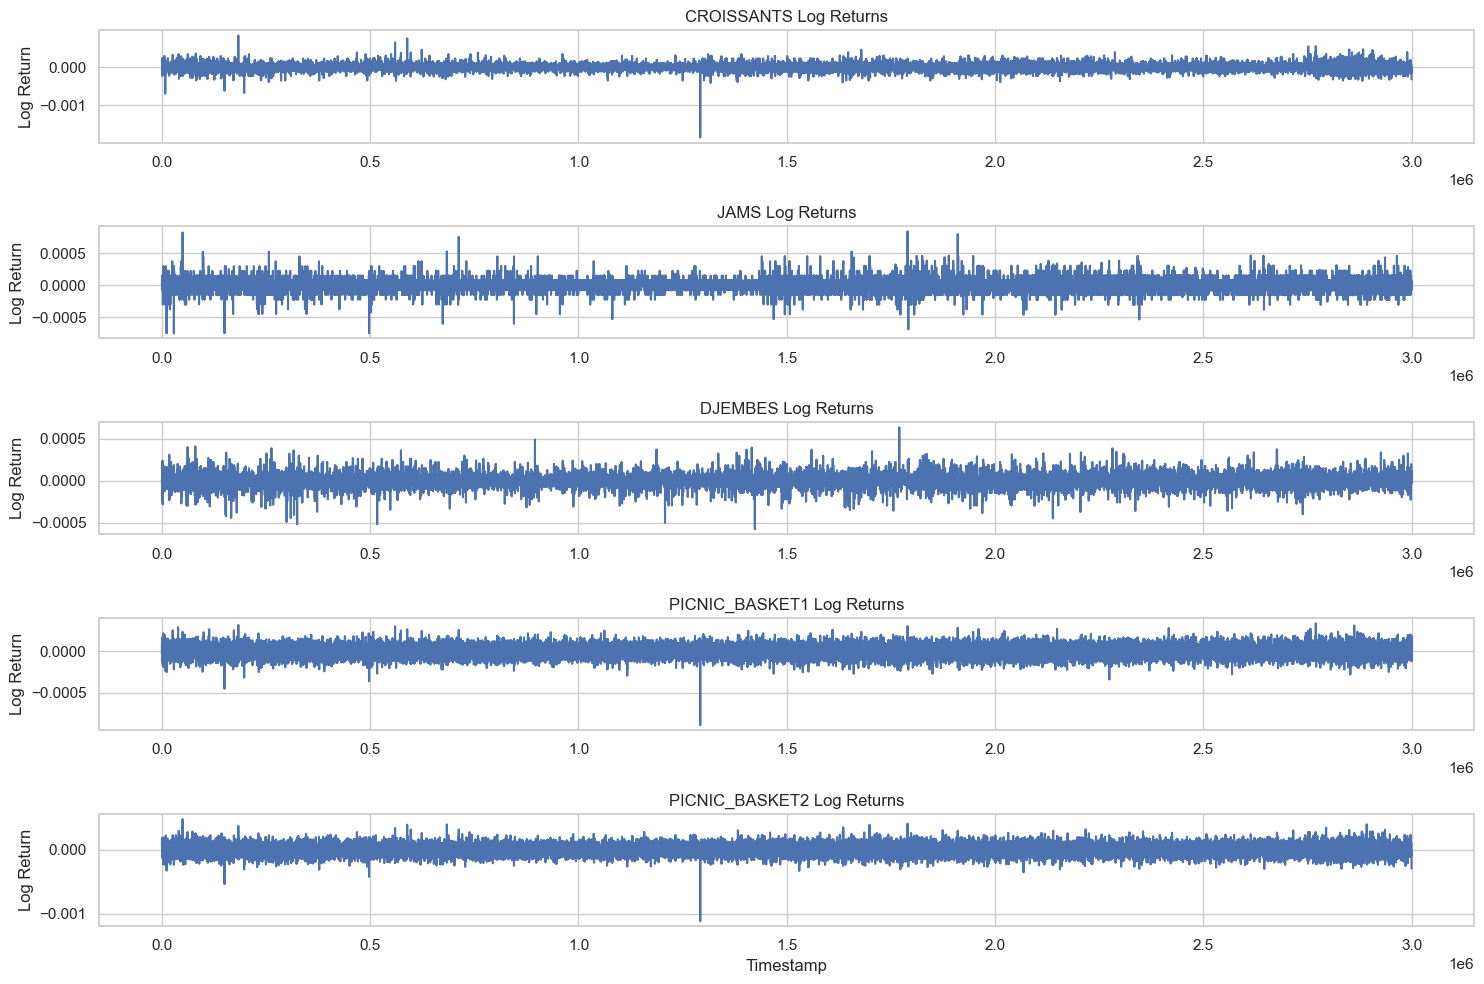

In [5]:
# Calculate log returns for each product
log_returns_df = np.log(prices_df).diff().dropna()

# Display the first few rows of log returns
print("Log returns:")
display(log_returns_df.head())

# Plot the log returns for each product
plt.figure(figsize=(15, 10))

for i, product in enumerate(log_returns_df.columns, 1):
    plt.subplot(len(log_returns_df.columns), 1, i)
    plt.plot(log_returns_df.index, log_returns_df[product])
    plt.title(f'{product} Log Returns')
    plt.ylabel('Log Return')
    if i == len(log_returns_df.columns):  # Only add x-label for the bottom plot
        plt.xlabel('Timestamp')

plt.tight_layout()
plt.show()

In [26]:
round(log_returns_df.corr(),2)

,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1,PICNIC_BASKET2
CROISSANTS,1.00,0.01,0.01,0.41,0.46
JAMS,0.01,1.00,-0.01,0.30,0.34
DJEMBES,0.01,-0.01,1.00,0.20,-0.01
PICNIC_BASKET1,0.41,0.30,0.20,1.00,0.34
PICNIC_BASKET2,0.46,0.34,-0.01,0.34,1.00


In [6]:
# Function to perform ADF test and interpret results
def adf_test(series, product_name):
    result = adfuller(series.dropna())
    
    # Extract and format the results
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Print the results
    print(f'ADF Test for {product_name}')
    print(f'ADF Statistic: {adf_stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value:.4f}')
    
    # Interpret the results
    if p_value <= 0.05:
        print('Conclusion: The series is stationary (reject H0)')
    else:
        print('Conclusion: The series is non-stationary (fail to reject H0)')
    
    print('\n')
    
    return p_value <= 0.05  # Return True if stationary

# Test stationarity for each product's log returns
stationarity_results = {}

for product in log_returns_df.columns:
    stationarity_results[product] = adf_test(log_returns_df[product], product)

ADF Test for CROISSANTS
ADF Statistic: -84.6234
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)


ADF Test for JAMS
ADF Statistic: -39.4462
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)


ADF Test for DJEMBES
ADF Statistic: -117.2968
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)


ADF Test for PICNIC_BASKET1
ADF Statistic: -84.4750
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)


ADF Test for PICNIC_BASKET2
ADF Statistic: -83.2631
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)




## VAR Model Fitting

Now we'll fit a Vector Autoregression (VAR) model to the log returns data.

In [7]:
# Handle missing values by forward filling and then backward filling
model_data = log_returns_df.fillna(method='ffill').fillna(method='bfill')

# Create a VAR model
var_model = VAR(model_data)

# Determine the optimal lag order using AIC
max_lags = 15
lag_order_results = var_model.select_order(maxlags=max_lags)
print("Optimal lag order according to different information criteria:")
print(lag_order_results.summary())

# Get the optimal lag order according to AIC
optimal_lag = lag_order_results.aic
print(f"\nOptimal lag order according to AIC: {optimal_lag}")

# Fit the VAR model with the optimal lag order
fitted_model = var_model.fit(optimal_lag)
print("\nVAR Model Summary:")
print(fitted_model.summary())

C:\Users\fujos\AppData\Local\Temp\ipykernel_66828\1887050951.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  model_data = log_returns_df.fillna(method='ffill').fillna(method='bfill')
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal lag order according to different information criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -96.24      -96.24   1.601e-42      -96.24
1      -96.26*     -96.25*  1.566e-42*     -96.26*
2       -96.26      -96.24   1.566e-42      -96.26
3       -96.26      -96.24   1.567e-42      -96.25
4       -96.26      -96.23   1.568e-42      -96.25
5       -96.26      -96.22   1.570e-42      -96.25
6       -96.26      -96.21   1.571e-42      -96.24
7       -96.26      -96.21   1.573e-42      -96.24
8       -96.25      -96.20   1.574e-42      -96.24
9       -96.25      -96.19   1.575e-42      -96.23
10      -96.25      -96.18   1.577e-42      -96.23
11      -96.25      -96.17   1.578e-42      -96.23
12      -96.25      -96.17   1.580e-42      -96.22
13      -96.25      -96.16   1.581e-42      -96.22
14      -96.25      -96.15   1.582e-42      -96.22
15      -96.25     

## Model Diagnostics

Let's check the model residuals to ensure they are well-behaved.

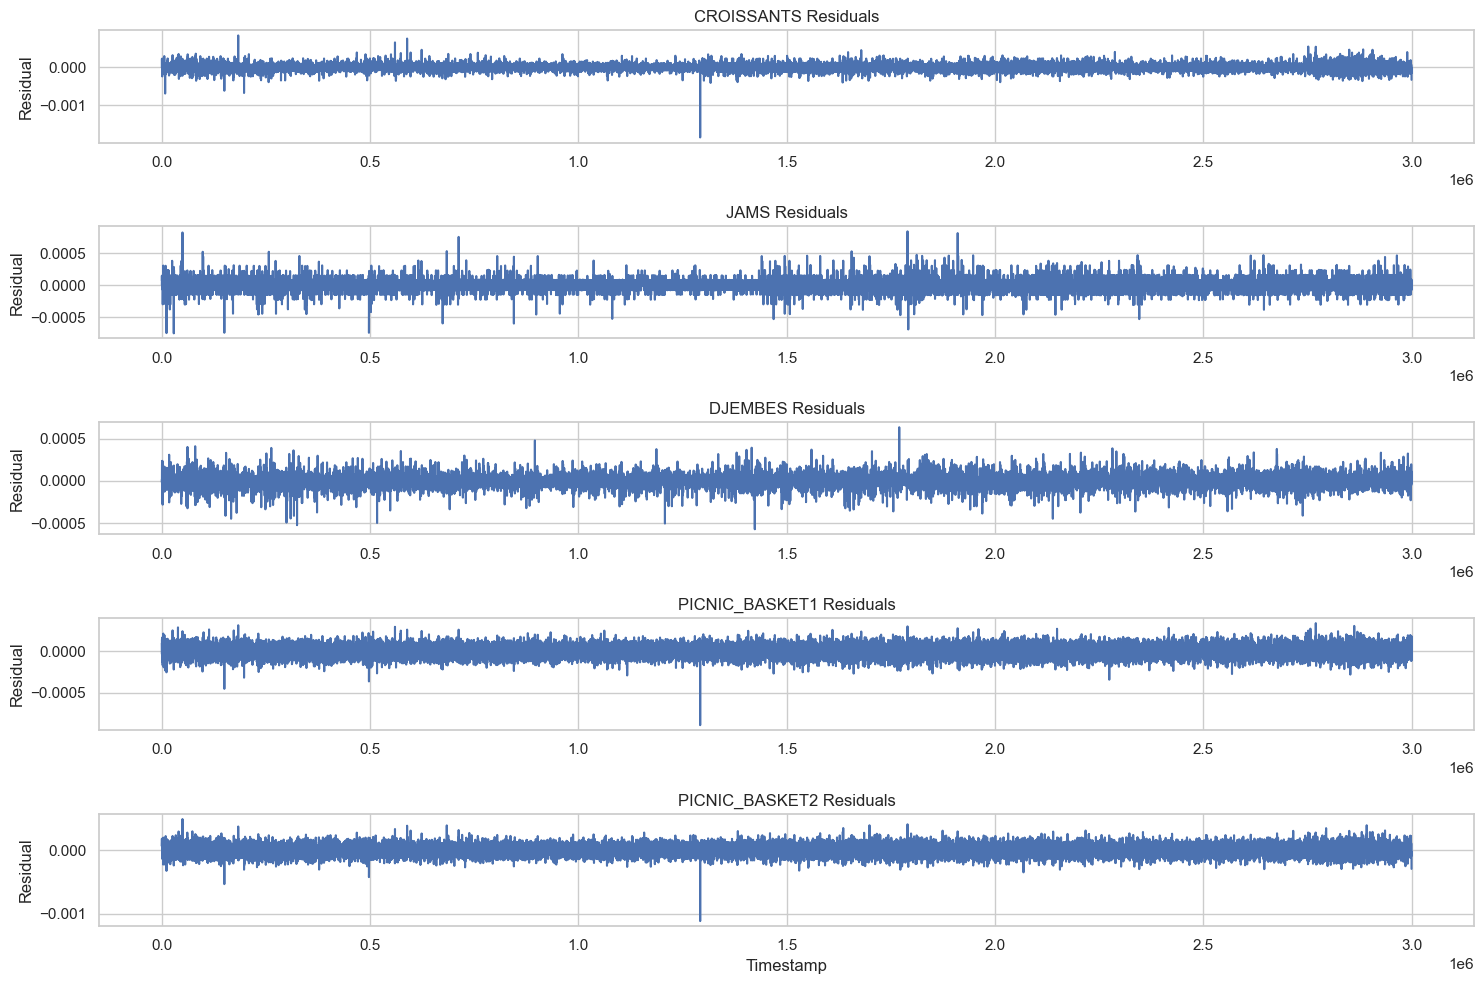

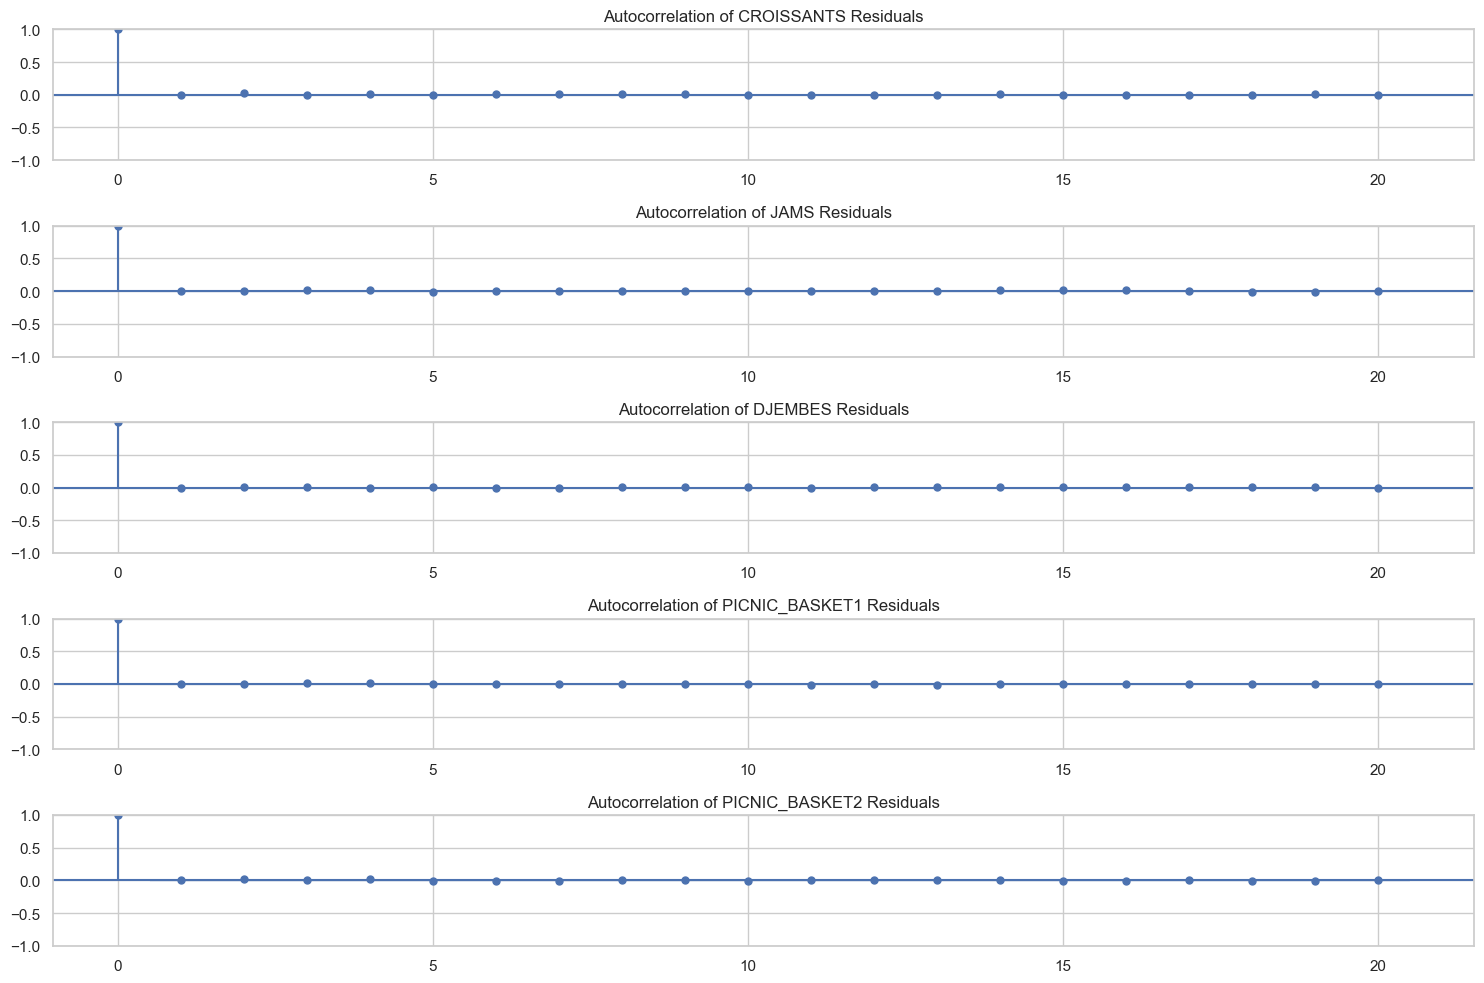

In [8]:
# Get the model residuals
residuals = fitted_model.resid

# Plot the residuals
plt.figure(figsize=(15, 10))

for i, product in enumerate(residuals.columns, 1):
    plt.subplot(len(residuals.columns), 1, i)
    plt.plot(residuals.index, residuals[product])
    plt.title(f'{product} Residuals')
    plt.ylabel('Residual')
    if i == len(residuals.columns):  # Only add x-label for the bottom plot
        plt.xlabel('Timestamp')

plt.tight_layout()
plt.show()

# Plot the autocorrelation of residuals
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(15, 10))

for i, product in enumerate(residuals.columns, 1):
    plt.subplot(len(residuals.columns), 1, i)
    plot_acf(residuals[product], lags=20, ax=plt.gca())
    plt.title(f'Autocorrelation of {product} Residuals')

plt.tight_layout()
plt.show()

## Granger Causality Tests

Let's perform Granger causality tests to understand the causal relationships between the variables.

In [14]:
# Perform Granger causality tests
causality_results = {}

for i, product1 in enumerate(model_data.columns):
    causality_results[product1] = {}
    
    for j, product2 in enumerate(model_data.columns):
        if i != j:  # Skip self-causality
            # Test if product1 Granger-causes product2
            test_result = fitted_model.test_causality(product2, [product1], kind='wald')
            
            causality_results[product1][product2] = {
                'test_statistic': test_result.test_statistic,
                'p_value': float(test_result.pvalue),
                'df': test_result.df,
                'significant': test_result.pvalue <= 0.05  # Using 5% significance level
            }
            
            # Print the result
            if test_result.pvalue <= 0.05:
                print(f'{product1} Granger-causes {product2} with p-value {test_result.pvalue:.4f}')
            else:
                print(f'No significant Granger causality from {product1} to {product2} (p-value: {test_result.pvalue:.4f})')

CROISSANTS Granger-causes JAMS with p-value 0.0000
No significant Granger causality from CROISSANTS to DJEMBES (p-value: 0.6015)
CROISSANTS Granger-causes PICNIC_BASKET1 with p-value 0.0000
CROISSANTS Granger-causes PICNIC_BASKET2 with p-value 0.0000
JAMS Granger-causes CROISSANTS with p-value 0.0000
No significant Granger causality from JAMS to DJEMBES (p-value: 0.9070)
JAMS Granger-causes PICNIC_BASKET1 with p-value 0.0001
JAMS Granger-causes PICNIC_BASKET2 with p-value 0.0005
DJEMBES Granger-causes CROISSANTS with p-value 0.0015
DJEMBES Granger-causes JAMS with p-value 0.0050
No significant Granger causality from DJEMBES to PICNIC_BASKET1 (p-value: 0.7127)
No significant Granger causality from DJEMBES to PICNIC_BASKET2 (p-value: 0.1393)
PICNIC_BASKET1 Granger-causes CROISSANTS with p-value 0.0000
PICNIC_BASKET1 Granger-causes JAMS with p-value 0.0000
No significant Granger causality from PICNIC_BASKET1 to DJEMBES (p-value: 0.9819)
No significant Granger causality from PICNIC_BASKET1

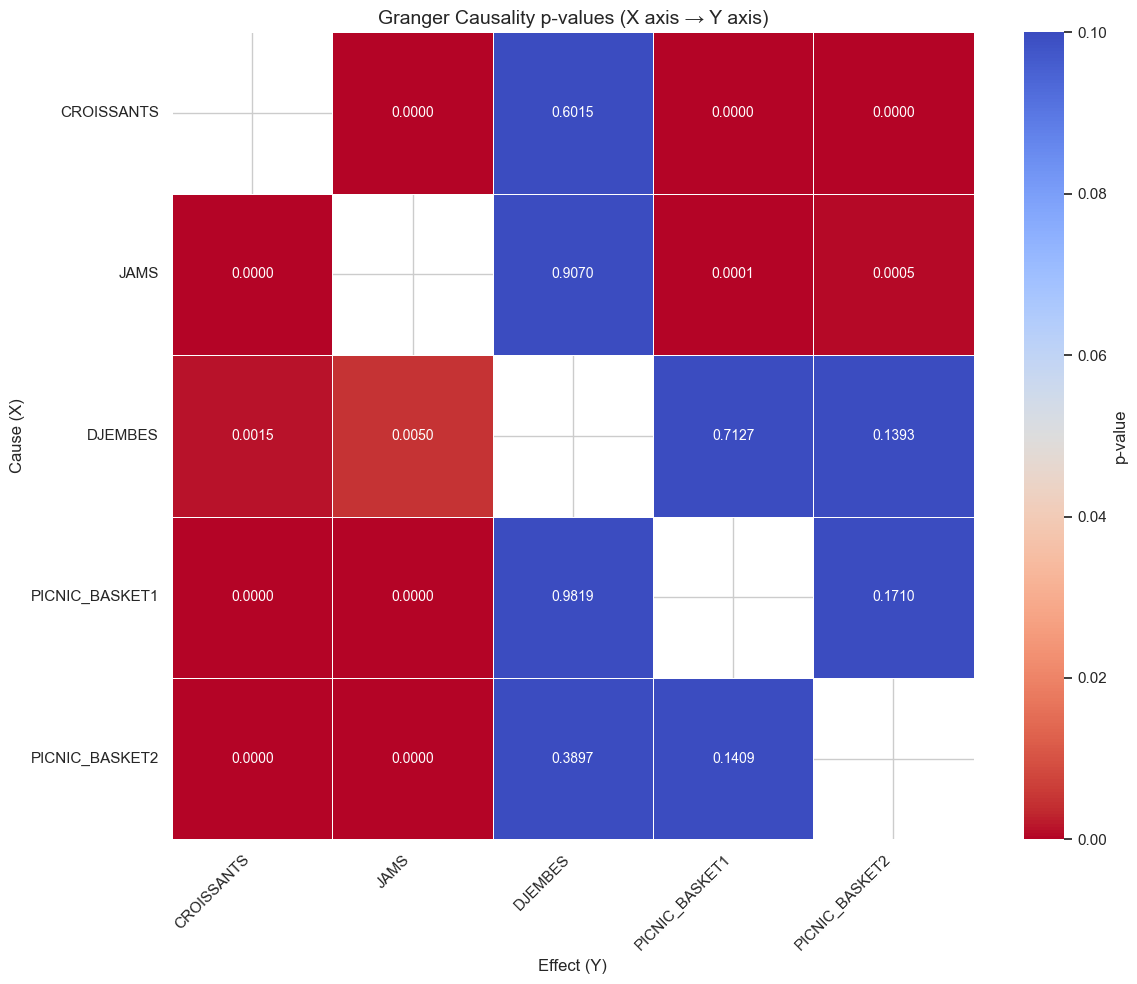

In [16]:
# Create a matrix of p-values for heatmap visualization
p_value_matrix = pd.DataFrame(index=model_data.columns, columns=model_data.columns)

for product1 in model_data.columns:
    for product2 in model_data.columns:
        if product1 == product2:
            p_value_matrix.loc[product1, product2] = 1.0  # Self-causality is not tested
        else:
            p_value_matrix.loc[product1, product2] = float(causality_results[product1][product2]['p_value'])

# Convert all values to float explicitly
p_value_matrix = p_value_matrix.astype(float)

# Create a heatmap of p-values
plt.figure(figsize=(12, 10))

# Mask the diagonal (self-causality) for better visualization
mask = np.zeros_like(p_value_matrix, dtype=bool)
np.fill_diagonal(mask, True)

# Create the heatmap with improved formatting
sns.heatmap(p_value_matrix, annot=True, cmap='coolwarm_r', vmin=0, vmax=0.1, 
           linewidths=0.5, cbar_kws={'label': 'p-value'}, mask=mask, 
           annot_kws={'size': 10}, fmt='.4f')
plt.title('Granger Causality p-values (X axis → Y axis)', fontsize=14)
plt.xlabel('Effect (Y)', fontsize=12)
plt.ylabel('Cause (X)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Impulse Response Analysis

Let's analyze how a shock to one variable affects the other variables over time.

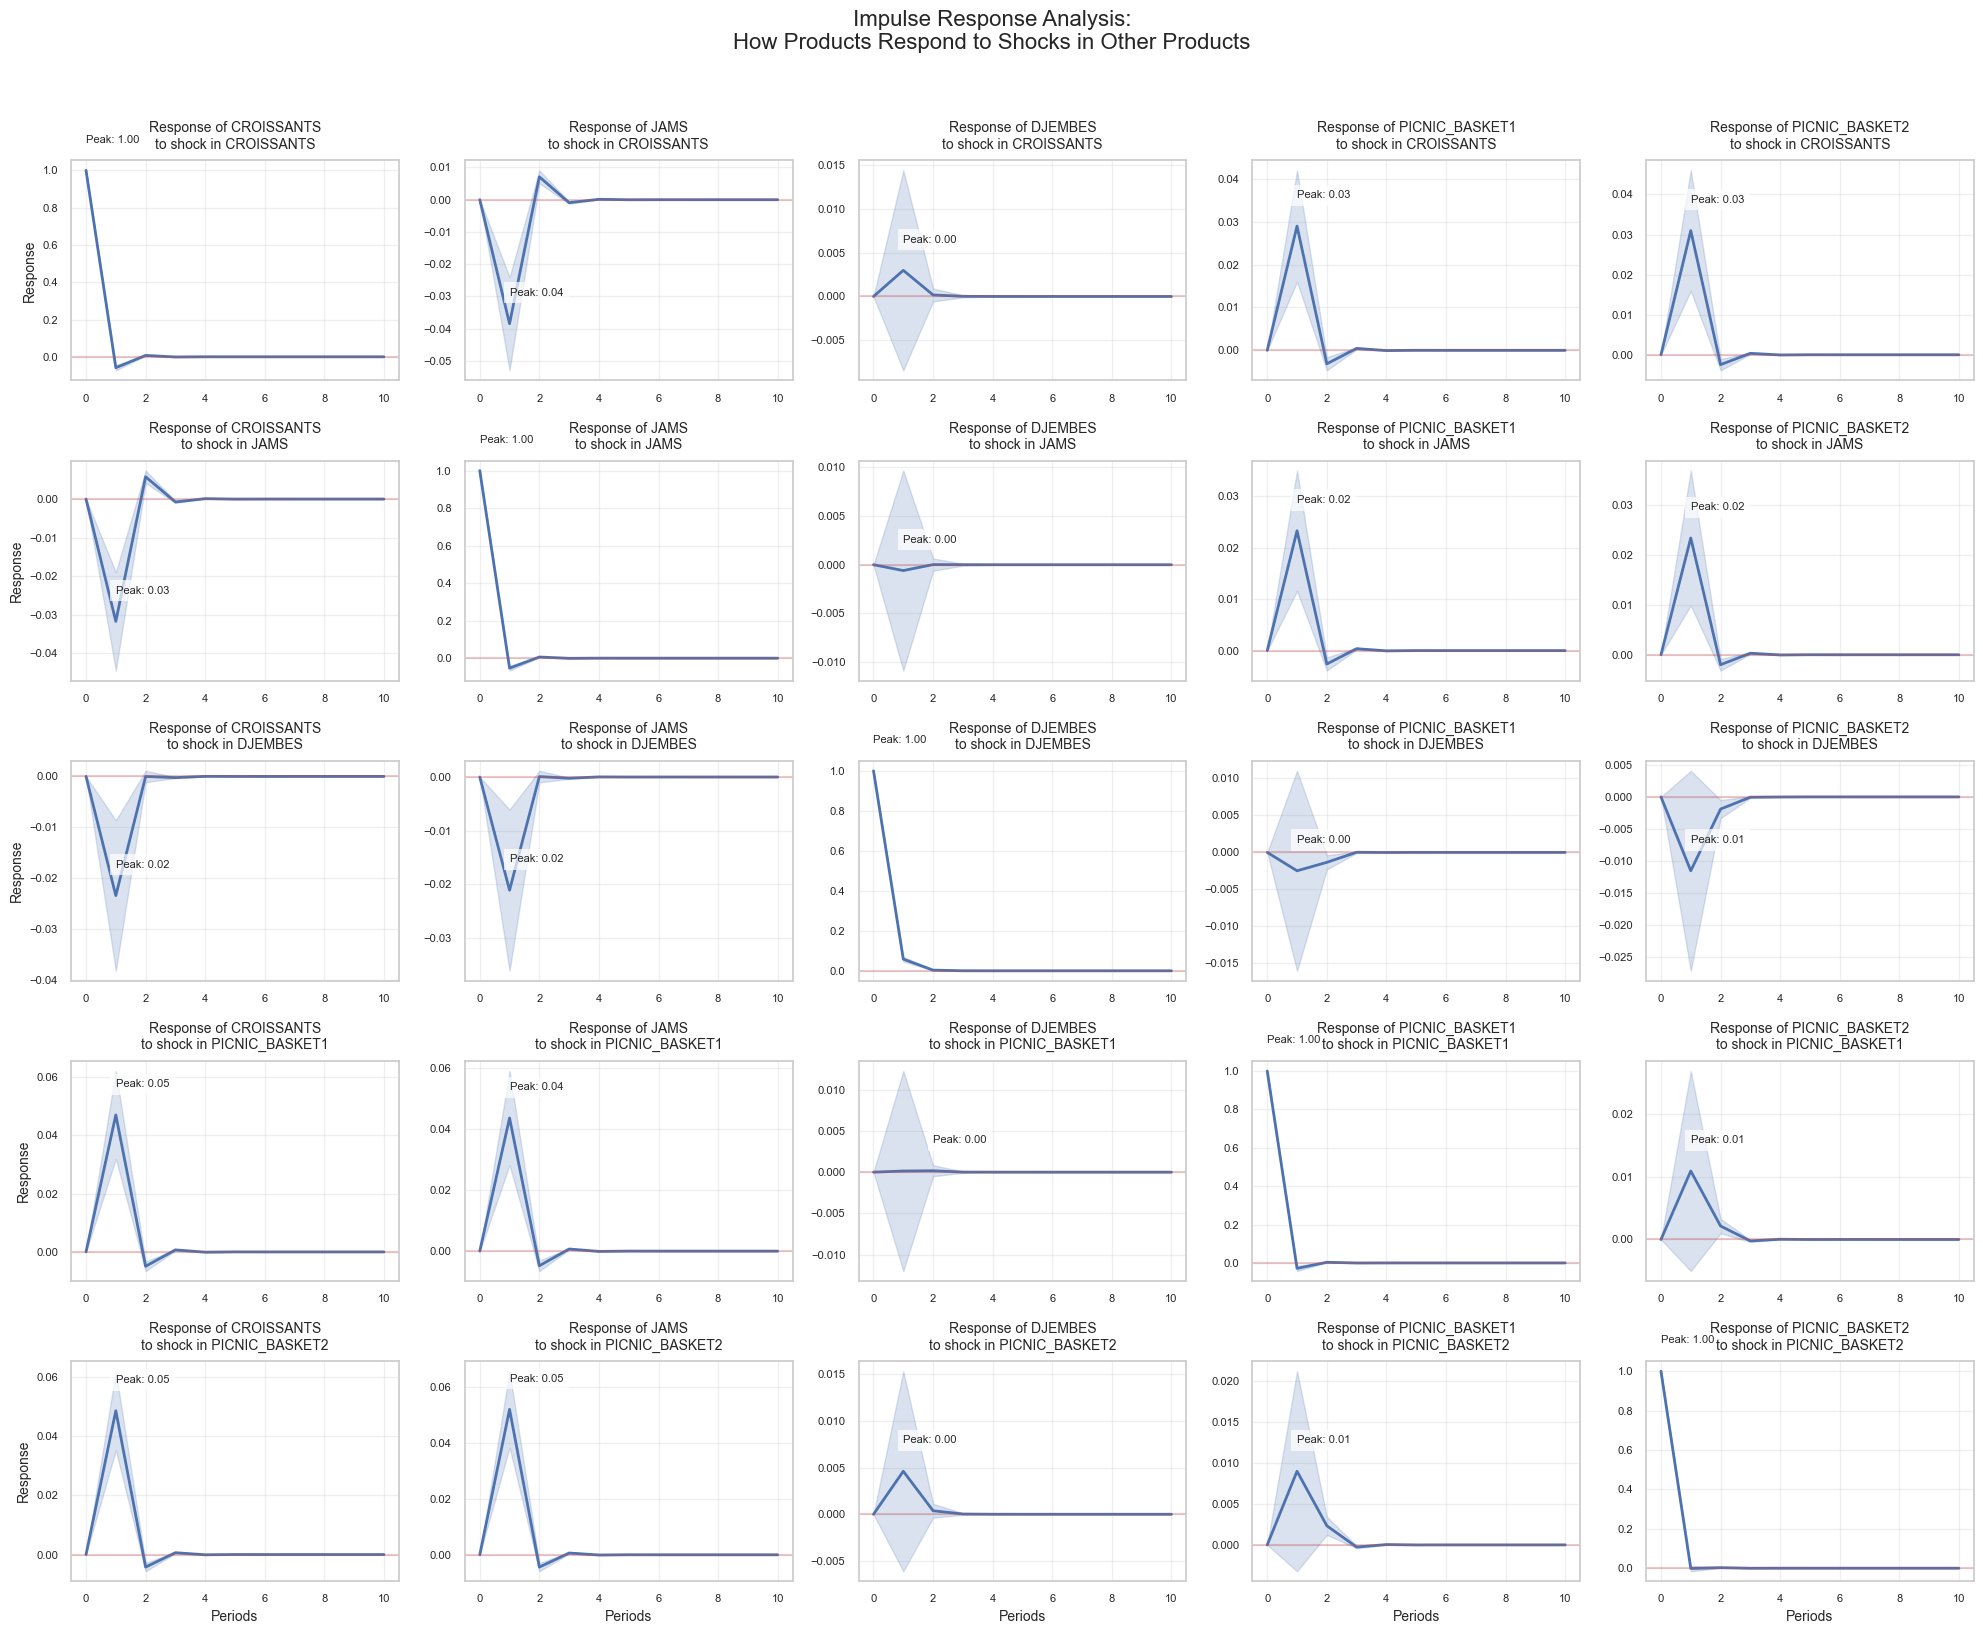


Summary of Significant Responses:
--------------------------------------------------

PICNIC_BASKET2 → JAMS
  • Peak response: 0.052
  • Time to peak: 1 periods
  • Persistence: Low


In [25]:
# Perform impulse response analysis
irf = fitted_model.irf(periods=10)

# Get standard errors
stderr = irf.stderr()  # Call the method to get the standard errors

# Create figure with more space and better dimensions
plt.figure(figsize=(20, 16))

# Add padding between subplots and overall figure
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, product1 in enumerate(model_data.columns):
    for j, product2 in enumerate(model_data.columns):
        plt.subplot(len(model_data.columns), len(model_data.columns), i*len(model_data.columns) + j + 1)
        
        # Plot the impulse response
        response = irf.irfs[:, j, i]
        plt.plot(range(len(response)), response, 'b-', linewidth=2, label='Response')
        
        # Add confidence intervals
        try:
            std_err = stderr[:, j, i]
            plt.fill_between(range(len(response)),
                           response - 2*std_err,
                           response + 2*std_err,
                           color='b', alpha=0.2,
                           label='95% CI')
        except Exception as e:
            print(f"Warning: Could not plot confidence intervals - {e}")
        
        # Improved title formatting
        plt.title(f'Response of {product2}\nto shock in {product1}', 
                 fontsize=10, 
                 pad=10,
                 wrap=True)
        
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.grid(True, alpha=0.3)
        
        # Add peak response annotation with better positioning
        peak_response = max(abs(response))
        peak_time = np.argmax(abs(response))
        plt.annotate(f'Peak: {peak_response:.2f}',
                    xy=(peak_time, response[peak_time]),
                    xytext=(0, 20), 
                    textcoords='offset points',
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        # Improve axis labels
        if i == len(model_data.columns) - 1:  # Bottom row
            plt.xlabel('Periods', fontsize=10)
        if j == 0:  # Leftmost column
            plt.ylabel('Response', fontsize=10)
            
        # Increase tick label size
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

# Add main title with better positioning
plt.suptitle('Impulse Response Analysis:\nHow Products Respond to Shocks in Other Products', 
             fontsize=16, 
             y=1.02)

plt.tight_layout()
plt.show()

# Print summary statistics in a more readable format
print("\nSummary of Significant Responses:")
print("-" * 50)
for i, product1 in enumerate(model_data.columns):
    for j, product2 in enumerate(model_data.columns):
        if i != j:  # Skip self-responses
            response = irf.irfs[:, j, i]
            peak = max(abs(response))
            if peak > 0.05:  # Only show significant responses
                print(f"\n{product1} → {product2}")
                print(f"  • Peak response: {peak:.3f}")
                print(f"  • Time to peak: {np.argmax(abs(response))} periods")
                print(f"  • Persistence: {'High' if abs(response[-1]) > 0.02 else 'Low'}")

## Forecast Evaluation

Let's evaluate the forecasting performance of our VAR model.

c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Root Mean Squared Error (RMSE) for each variable:
CROISSANTS: 0.000085
JAMS: 0.000074
DJEMBES: 0.000060
PICNIC_BASKET1: 0.000071
PICNIC_BASKET2: 0.000083


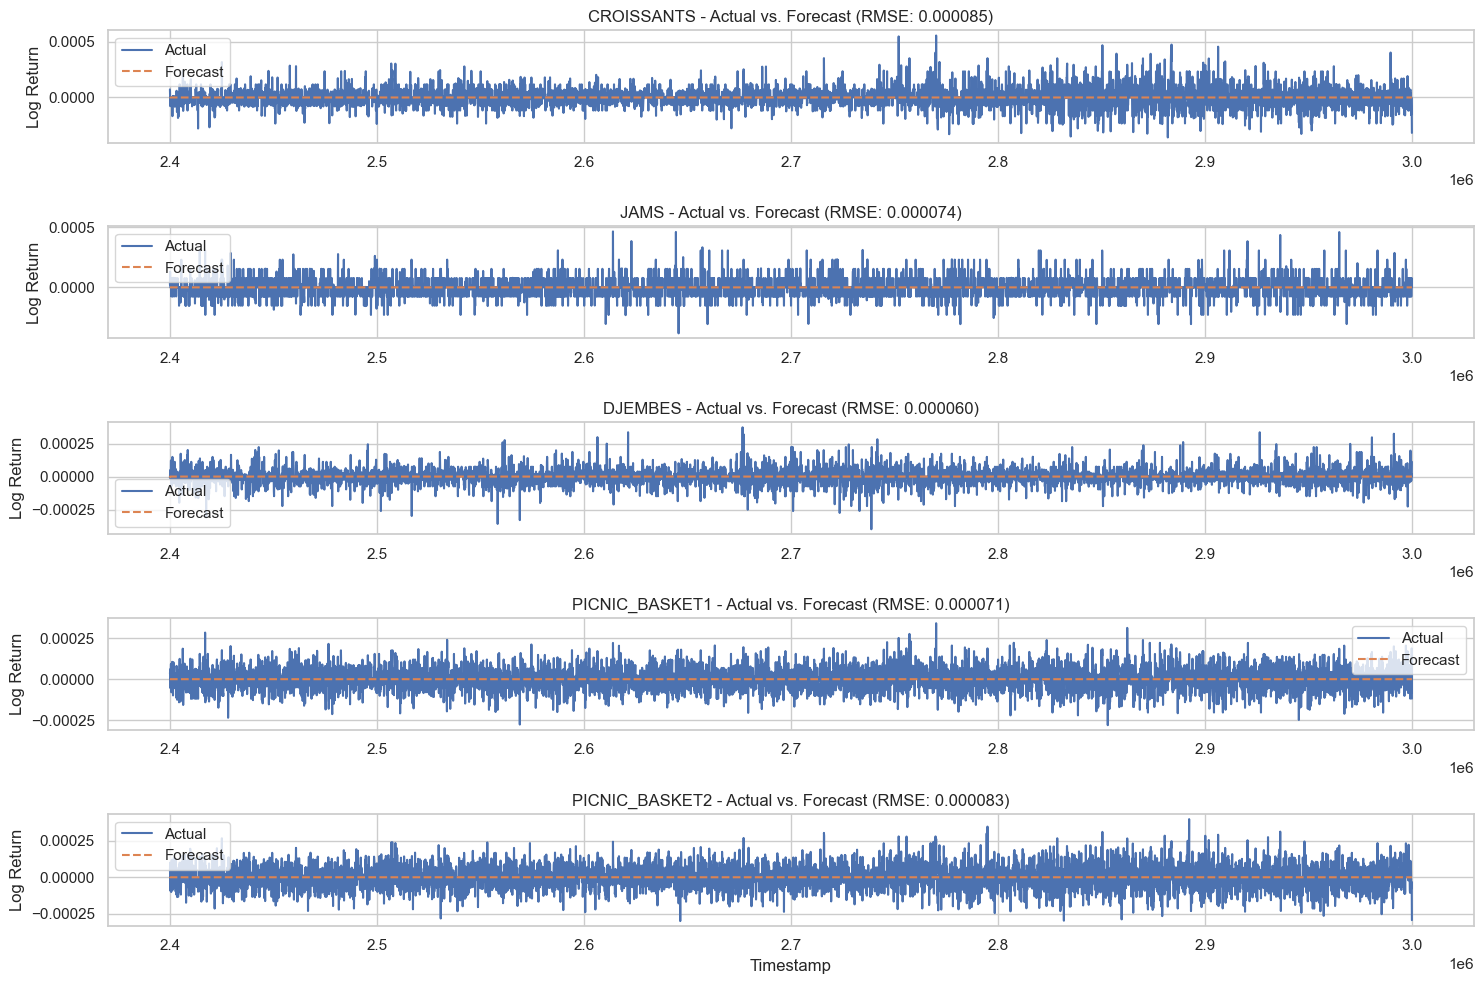

In [27]:
# Split the data into training and testing sets
train_size = int(len(model_data) * 0.8)
train_data = model_data.iloc[:train_size]
test_data = model_data.iloc[train_size:]

# Fit the VAR model on the training data
var_model_train = VAR(train_data)
fitted_model_train = var_model_train.fit(optimal_lag)

# Forecast for the test period
forecast_steps = len(test_data)
forecasts = fitted_model_train.forecast(train_data.values[-optimal_lag:], forecast_steps)

# Convert forecasts to DataFrame
forecast_df = pd.DataFrame(forecasts, index=test_data.index, columns=test_data.columns)

# Calculate RMSE for each variable
rmse_values = {}
for column in test_data.columns:
    rmse_values[column] = rmse(test_data[column], forecast_df[column])

# Display RMSE values
print("Root Mean Squared Error (RMSE) for each variable:")
for product, value in rmse_values.items():
    print(f"{product}: {value:.6f}")

# Plot actual vs. forecast for each variable
plt.figure(figsize=(15, 10))

for i, product in enumerate(test_data.columns, 1):
    plt.subplot(len(test_data.columns), 1, i)
    plt.plot(test_data.index, test_data[product], label='Actual')
    plt.plot(forecast_df.index, forecast_df[product], label='Forecast', linestyle='--')
    plt.title(f'{product} - Actual vs. Forecast (RMSE: {rmse_values[product]:.6f})')
    plt.ylabel('Log Return')
    plt.legend()
    if i == len(test_data.columns):  # Only add x-label for the bottom plot
        plt.xlabel('Timestamp')

plt.tight_layout()
plt.show()

## Variance Decomposition

Let's analyze the contribution of each variable to the forecast error variance of the other variables.

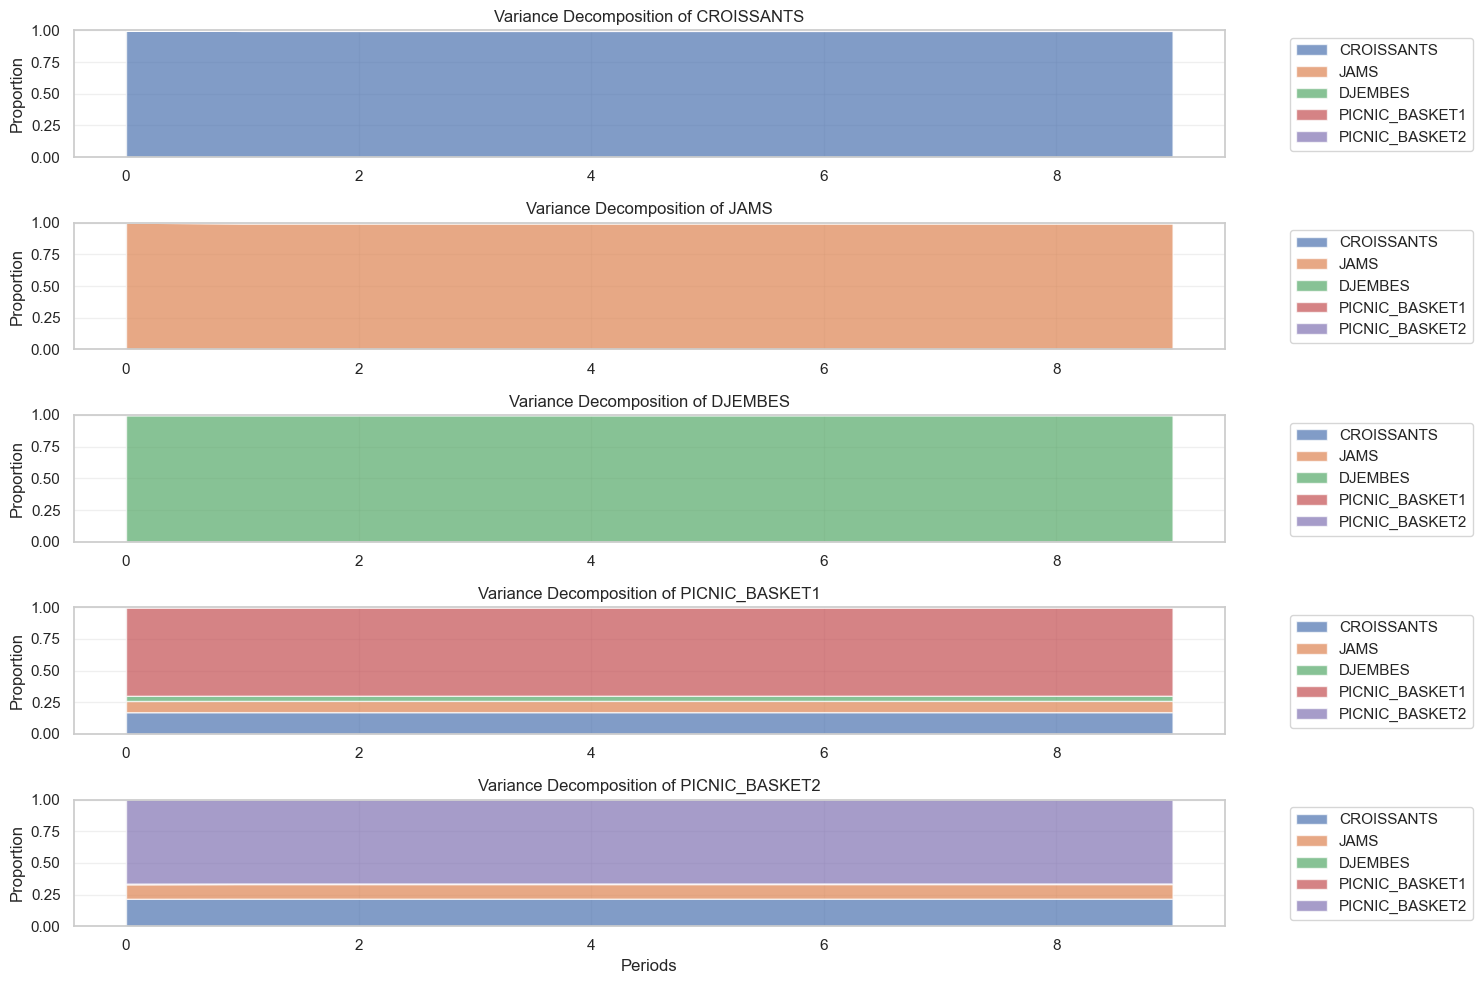


Variance Decomposition Summary:
--------------------------------------------------

Decomposition for CROISSANTS:
CROISSANTS        0.997
JAMS              0.000
DJEMBES           0.000
PICNIC_BASKET1    0.002
PICNIC_BASKET2    0.002
dtype: float64

Decomposition for JAMS:
CROISSANTS        0.000
JAMS              0.997
DJEMBES           0.000
PICNIC_BASKET1    0.001
PICNIC_BASKET2    0.002
dtype: float64

Decomposition for DJEMBES:
CROISSANTS        0.0
JAMS              0.0
DJEMBES           1.0
PICNIC_BASKET1    0.0
PICNIC_BASKET2    0.0
dtype: float64

Decomposition for PICNIC_BASKET1:
CROISSANTS        0.172
JAMS              0.089
DJEMBES           0.041
PICNIC_BASKET1    0.698
PICNIC_BASKET2    0.000
dtype: float64

Decomposition for PICNIC_BASKET2:
CROISSANTS        0.218
JAMS              0.116
DJEMBES           0.000
PICNIC_BASKET1    0.004
PICNIC_BASKET2    0.662
dtype: float64

Interpretation:
--------------------------------------------------

CROISSANTS:
  • Own shocks e

In [31]:
# Perform forecast error variance decomposition
fevd = fitted_model.fevd(periods=10)

# Create figure
plt.figure(figsize=(15, 10))

# Manual plotting of FEVD
for i, product_idx in enumerate(range(len(model_data.columns))):
    plt.subplot(len(model_data.columns), 1, i + 1)
    
    # Get decomposition for this variable
    decomp = fevd.decomp[i]  # Use integer index instead of product name
    product = model_data.columns[i]  # Get product name for labels
    
    # Create stacked area plot
    x = range(decomp.shape[0])
    plt.stackplot(x, decomp.T, 
                 labels=model_data.columns,
                 alpha=0.7)
    
    plt.title(f'Variance Decomposition of {product}')
    plt.ylabel('Proportion')
    plt.xlabel('Periods' if i == len(model_data.columns) - 1 else '')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set y-axis limits
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Print numerical decomposition
print("\nVariance Decomposition Summary:")
print("-" * 50)
for i, product in enumerate(model_data.columns):
    print(f"\nDecomposition for {product}:")
    decomp = fevd.decomp[i]  # Use integer index
    # Show final period decomposition
    final_decomp = pd.Series(decomp[-1], index=model_data.columns)
    print(final_decomp.round(3))

# Add interpretation
print("\nInterpretation:")
print("-" * 50)
for i, product in enumerate(model_data.columns):
    decomp = fevd.decomp[i]
    final_decomp = pd.Series(decomp[-1], index=model_data.columns)
    main_drivers = final_decomp[final_decomp > 0.1].index.tolist()
    print(f"\n{product}:")
    print(f"  • Own shocks explain {final_decomp[product]:.1%} of variance")
    if len(main_drivers) > 1:
        other_drivers = [d for d in main_drivers if d != product]
        if other_drivers:
            print(f"  • Other significant drivers: {', '.join(other_drivers)}")

## Conclusion

In this notebook, we performed Vector Autoregression (VAR) analysis on the picnic basket components to understand their dynamic relationships and forecast future values. Key findings include:

1. The stationarity tests confirmed that the log returns of all products are stationary, making them suitable for VAR modeling.
2. The optimal lag order for the VAR model was determined using information criteria.
3. Granger causality tests revealed significant causal relationships between certain products.
4. Impulse response analysis showed how shocks to one product affect the others over time.
5. Forecast evaluation demonstrated the predictive performance of the VAR model.
6. Variance decomposition provided insights into the contribution of each product to the forecast error variance of the others.

These insights can help inform trading strategies that exploit the dynamic relationships between the picnic basket components.